In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
labels = ['glioma','notumor','meningioma','pituitary']

In [3]:
X_train = []
y_train = []
image_size = 150

In [5]:
for i in labels:
    folderPath = os.path.join('image dataset/Training',i)
    for j in tqdm(os.listdir(folderPath), ncols = 120, desc = 'Training: '+str(i)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

Training: pituitary: 100%|██████████████████████████████████████████████████████████| 1457/1457 [00:17<00:00, 84.85it/s]


In [6]:
for i in labels:
    folderPath = os.path.join('image dataset/Testing',i)
    for j in tqdm(os.listdir(folderPath), ncols = 120, desc = 'Testing: '+str(i)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

Testing: pituitary: 100%|█████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 93.97it/s]


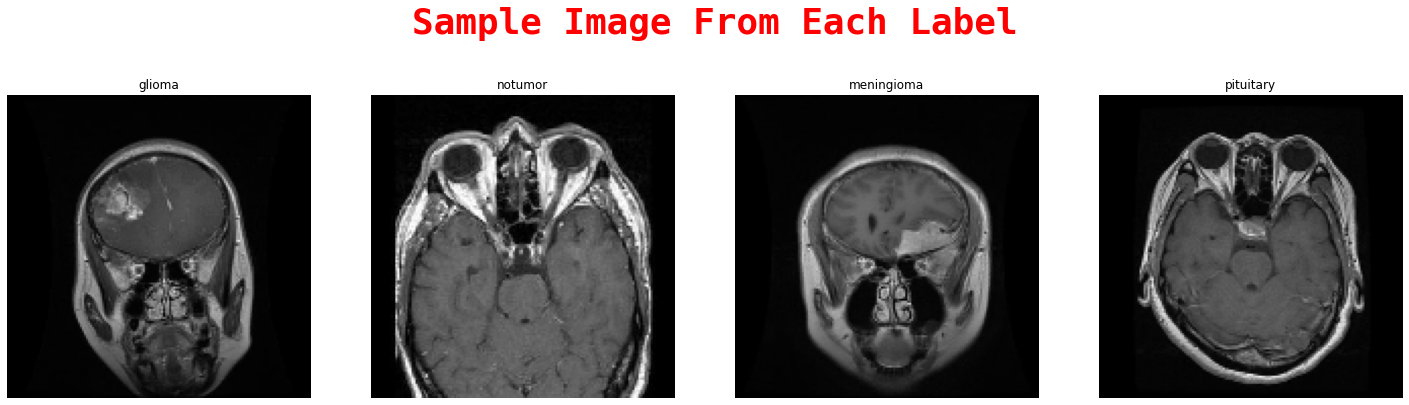

In [7]:
k=0
fig, ax = plt.subplots(1,4,figsize=(25,20))
fig.text(s='Sample Image From Each Label',size=36,fontweight='bold',
             fontname='monospace',color='#ff0000',y=0.65,x=0.35,alpha=1)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [8]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [9]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [10]:
print("X_train: ", X_train.shape,'\n',"y_train: ", y_train.shape)

X_train:  (7025, 150, 150, 3) 
 y_train:  (7025,)


### splitting the data into training and testing

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [12]:
print('X_train-shape:', X_train.shape,'\ny_train-shape: ', y_train.shape, '\nX_tset-shape: ', X_test.shape, '\ny_test-shape: ', y_test.shape)

X_train-shape: (6322, 150, 150, 3) 
y_train-shape:  (6322,) 
X_tset-shape:  (703, 150, 150, 3) 
y_test-shape:  (703,)


In [13]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

In [14]:
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

## **Implementing MobileNet**

In [15]:
mobnet = MobileNet(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

17225924/17225924 [==============================] - 6s 0us/step


### Implementing Transfer Learning

In [16]:
mobnet_model = mobnet.output
mobnet_model = tf.keras.layers.GlobalAveragePooling2D()(mobnet_model)
mobnet_model = tf.keras.layers.Dropout(rate=0.5)(mobnet_model)
mobnet_model = tf.keras.layers.Dense(4,activation='softmax')(mobnet_model)
mobnet_model = tf.keras.models.Model(inputs=mobnet.input, outputs = mobnet_model)

In [17]:
mobnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 9, 9, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 9, 9, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 9, 9, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 9, 9, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 9, 9, 512)         0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 9, 9, 512)         262144    
                                                                 
 conv_pw_9

In [18]:
mobnet_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [19]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("mobnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

In [20]:
mobnet_history = mobnet_model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
178/178 [==============================] - ETA: 0s - loss: 0.4092 - accuracy: 0.8826
Epoch 1: val_accuracy improved from -inf to 0.75513, saving model to mobnet.h5
178/178 [==============================] - 190s 1s/step - loss: 0.4092 - accuracy: 0.8826 - val_loss: 1.3202 - val_accuracy: 0.7551 - lr: 0.0010
Epoch 2/12
178/178 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9575
Epoch 2: val_accuracy improved from 0.75513 to 0.96524, saving model to mobnet.h5
178/178 [==============================] - 196s 1s/step - loss: 0.1253 - accuracy: 0.9575 - val_loss: 0.1739 - val_accuracy: 0.9652 - lr: 0.0010
Epoch 3/12
178/178 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9682
Epoch 3: val_accuracy did not improve from 0.96524
178/178 [==============================] - 180s 1s/step - loss: 0.1002 - accuracy: 0.9682 - val_loss: 2.2387 - val_accuracy: 0.6335 - lr: 0.0010
Epoch 4/12
178/178 [==============================] - ETA: 0s - l

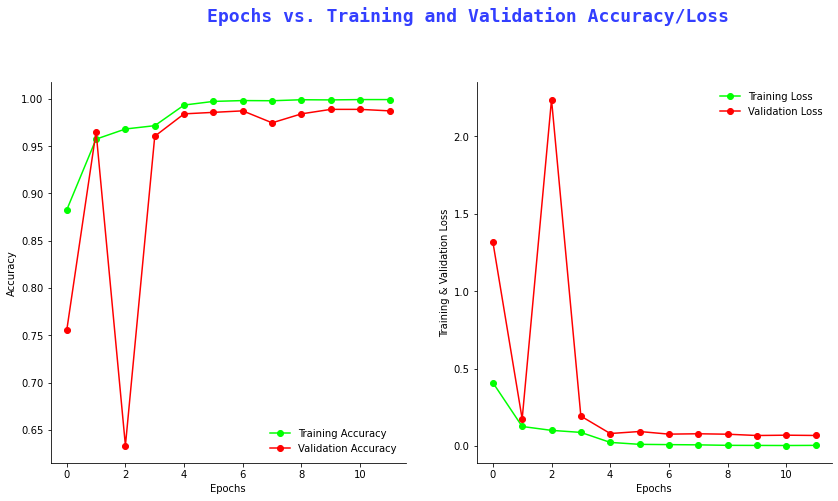

In [25]:
filterwarnings('ignore')
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = mobnet_history.history['accuracy']
train_loss = mobnet_history.history['loss']
val_acc = mobnet_history.history['val_accuracy']
val_loss = mobnet_history.history['val_loss']
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',
         size=18,
         fontweight='bold', 
         fontname='monospace',
         color='#000fff',y=1,x=0.28,alpha=0.8)
sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor='#00ff00',color='#00ff00', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor='#ff0000',color='#ff0000', label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor='#00ff00',color='#00ff00', label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor='#ff0000',color='#ff0000', label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
fig.show()

In [26]:
pred = mobnet_model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

22/22 [==============================] - 8s 194ms/step


In [27]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       170
           1       1.00      1.00      1.00       206
           2       0.98      0.99      0.98       147
           3       1.00      0.99      1.00       180

    accuracy                           0.99       703
   macro avg       0.99      0.99      0.99       703
weighted avg       0.99      0.99      0.99       703



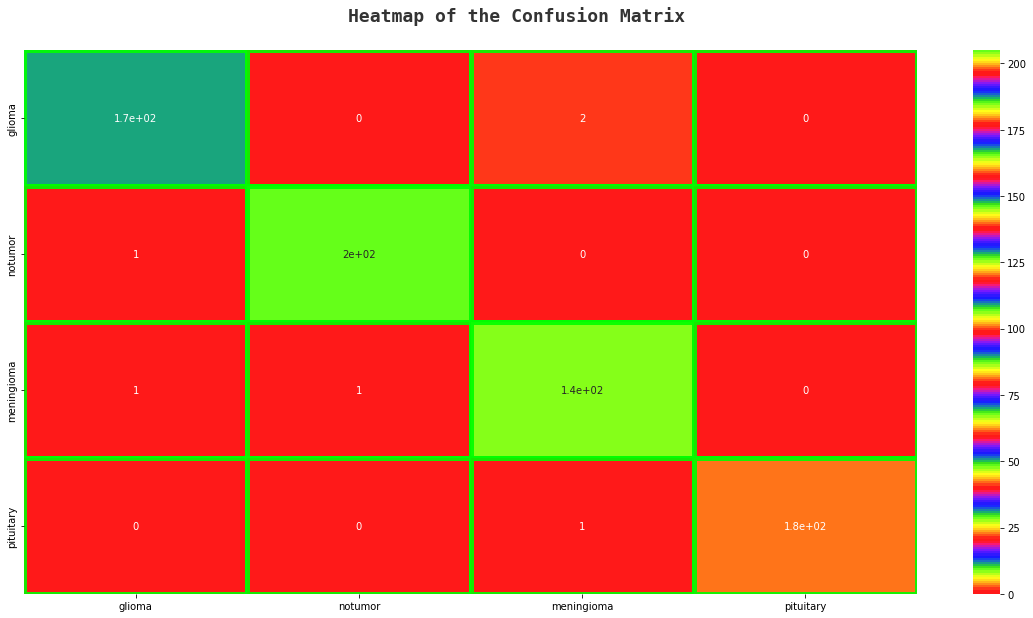

In [30]:
fig,ax=plt.subplots(1,1,figsize=(20,10))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True, cmap='prism',alpha=0.9,linewidths=5,linecolor='#00ff00')
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold', fontname='monospace',color='#000000',y=0.92,x=0.35,alpha=0.8)
plt.show()

In [32]:
A=accuracy_score(y_test_new, pred)
print("Model Accuracy is: ",np.round(A, 2)*100,'%.')

Model Accuracy is:  99.0 %.
